In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import mbuild as mb
import metamds as mds
import mdtraj as md

import nglview as nv

%matplotlib inline
!rm -rf output/ *.top *.gro

In [2]:
def build_monolayer(chain_length, n_molecules, **kwargs):
    from mbuild.examples import AlkaneMonolayer
    pattern = mb.Random2DPattern(n_molecules)
    monolayer = AlkaneMonolayer(pattern, tile_x=1, tile_y=1, 
                                chain_length=chain_length)
    mb.translate(monolayer, [0, 0, 2])
    return monolayer

In [5]:
monolayer = build_monolayer(5, 80)
monolayer.visualize()

/Users/ctk3b/science/python/mbuild/mbuild/recipes/monolayer.py:80: UserWarning: 
 No fractions provided.  Assuming a single chain type.
  warnings.warn("\n No fractions provided.  Assuming a single chain type.")
/Users/ctk3b/science/python/mbuild/mbuild/recipes/monolayer.py:83: UserWarning: 
 Adding 80 of chain <AlkylSilane 21 particles, non-periodic, 20 bonds, id: 4847375640>
  warnings.warn("\n Adding {} of chain {}".format(len(pattern), chains[-1]))


In [3]:
def create_run_script(build_func, forcefield, input_dir, **kwargs):
    compound = build_func(**kwargs)
    name = compound.name
    em = os.path.join(input_dir, 'em.mdp')
    nvt = os.path.join(input_dir, 'nvt.mdp')
    gro = '{name}.gro'.format(name=name)
    top = '{name}.top'.format(name=name)

    box = compound.boundingbox
    compound.periodicity += np.array([0, 0, 5 * box.lengths[2]])
    compound.save(top, forcefield=forcefield, overwrite=True)

    em_grompp = 'gmx grompp -f {mdp} -c {gro} -p {top} -o em.tpr'.format(mdp=em, gro=gro, top=top)
    em_mdrun = 'gmx mdrun -v -deffnm em -ntmpi 1'

    nvt_grompp = 'gmx grompp -f {mdp} -c em.gro -p {top} -o nvt.tpr'.format(mdp=nvt, top=top)
    nvt_mdrun = 'gmx mdrun -v -deffnm nvt -ntmpi 1'

    script = (em_grompp, em_mdrun, nvt_grompp, nvt_mdrun)
    return script

In [4]:
# Initialize simulation with a template and some metadata
sim = mds.Simulation(name='monolayer', 
                     template=create_run_script,
                     output_dir='output')

#chain_lengths = [8, 12, 16, 20]
chain_lengths = [8]
for length in chain_lengths:
    parameters = {'chain_length': length,
                  'n_molecules': 100, 
                  'forcefield': 'OPLS-aa',
                  'build_func': build_monolayer}
    # Parameterize our simulation template
    sim.parametrize(**parameters)

/Users/ctk3b/science/python/mbuild/mbuild/recipes/monolayer.py:80: UserWarning: 
 No fractions provided.  Assuming a single chain type.
  warnings.warn("\n No fractions provided.  Assuming a single chain type.")
/Users/ctk3b/science/python/mbuild/mbuild/recipes/monolayer.py:83: UserWarning: 
 Adding 100 of chain <AlkylSilane 30 particles, non-periodic, 29 bonds, id: 4679929472>
  warnings.warn("\n Adding {} of chain {}".format(len(pattern), chains[-1]))


In [6]:
#sim.execute_all(hostname='rahman.vuse.vanderbilt.edu', username='ctk3b')
sim.execute_all()

/Users/ctk3b/science/mbuild_screening/monolayers /Users/ctk3b/science/mbuild_screening/monolayers/output/task_0
gmx grompp -f ../../em.mdp -c AlkaneMonolayer.gro -p AlkaneMonolayer.top -o em.tpr
gmx mdrun -v -deffnm em -ntmpi 1
gmx grompp -f ../../nvt.mdp -c em.gro -p AlkaneMonolayer.top -o nvt.tpr
gmx mdrun -v -deffnm nvt -ntmpi 1


In [7]:
#sim.sync_all()

In [8]:
task_1 = next(sim.tasks())
trj_path = os.path.join(task_1.output_dir, 'nvt.xtc')
top_path = os.path.join(task_1.output_dir, 'em.gro')
traj = md.load(trj_path, top=top_path)
print(traj)

<mdtraj.Trajectory with 21 frames, 4900 atoms, 1 residues, and unitcells>


In [9]:
nv.show_mdtraj(traj)

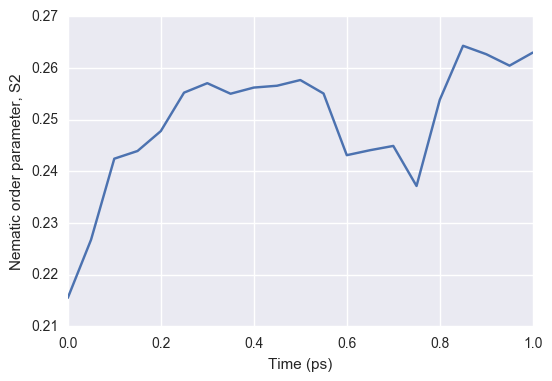

In [10]:
# Nematic order parameter
atoms_per_chain = int((traj.n_atoms - 1800) / 100)
chain_indices = [[n+x for x in range(atoms_per_chain)] 
                 for n in range(1800, traj.n_atoms, atoms_per_chain)]
s2 = md.compute_nematic_order(traj, indices=chain_indices)
    
plt.plot(traj.time, s2)
plt.xlabel('Time (ps)')
plt.ylabel('Nematic order parameter, S2')